In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping 

from elastica.rod.cosserat_rod import CosseratRod 
from elastica.dissipation import AnalyticalLinearDamper
from elastica.boundary_conditions import OneEndFixedBC
from elastica.external_forces import EndpointForces, GravityForces 
from elastica import Connections
from elastica import FixedJoint
from elastica.callback_functions import CallBackBaseClass
from elastica.timestepper import integrate, PositionVerlet
from elastica import CallBacks

from elastica.timestepper.symplectic_steppers import PositionVerlet
from collections import defaultdict
from magneto_pyelastica import *

In [55]:
m_size = 30
r_size = 3
microscope_size = 10
small_scope_size =10
magnetic_amplitudes =np.concatenate( (np.linspace(0,1,small_scope_size,endpoint=False),np.linspace(1,10,small_scope_size,endpoint=False),np.linspace(10,100,m_size-small_scope_size-microscope_size)),axis=0) #mT
length_diameter_ratio = np.linspace(10,20,3)
delta_div_L = np.zeros((r_size,m_size))
angles = np.zeros_like(delta_div_L)
for i in range(r_size):
    for j in range(m_size):
        #------simulator-------
        class UniformMRodSimulator(BaseSystemCollection, Constraints, Forcing, Damping, CallBacks):
            pass
        Uniform_M_Rod_Sim = UniformMRodSimulator()

        #------mmGS unit-------
        density = 2.273  #mg/mm^3 
        base_radius = 0.3 #mm 
        base_length = length_diameter_ratio[i] * base_radius * 2 #mm 
        scale_E = 1e-3 #scale down Young's modulus
        E = 1.4e9 * scale_E #Young's modulus
        shear_modulus = E/3 # shear modulus


        dt = 1.4e-4 # time step
        nu = 5
        endtime = 5

        #------rod definition----
        n_elem = 40
        start = np.zeros((3,))
        direction = np.array([0.0,1.0,0.0])
        normal = np.array([1.0,0.0,0.0])

        Uniform_M_Rod = CosseratRod.straight_rod(n_elem, start, direction, normal, base_length, base_radius, density, youngs_modulus=E, shear_modulus=shear_modulus)
        Uniform_M_Rod_Sim.append(Uniform_M_Rod)

        #------magnetic properties------
        magnetization_density = 1.28e5 *1e-3 #A/mm
        magnetization_direction = np.ones(n_elem) * direction.reshape(3,1) 

        magnetic_amplitude = magnetic_amplitudes[j]* 1e3 * scale_E #mg*mm^2 / (A*s^2)
        magnetic_angle = np.pi /2
        magnetic_field = magnetic_amplitude * np.array([0.0, np.cos(magnetic_angle), np.sin(magnetic_angle)]) 
        magnetic_field_object = ConstantMagneticField(
            magnetic_field, ramp_interval= 0.15, start_time = 0, end_time = 5
        )

        #------constraints-------
        Uniform_M_Rod_Sim.constrain(Uniform_M_Rod).using(
            OneEndFixedBC, constrained_position_idx = (0,), constrained_director_idx = (0,)
        )

        #------forcing-----------
        Uniform_M_Rod_Sim.add_forcing_to(Uniform_M_Rod).using(
            MagneticForces, 
            external_magnetic_field = magnetic_field_object,
            magnetization_density = magnetization_density,
            magnetization_direction = magnetization_direction,
            rod_volume = Uniform_M_Rod.volume,
            rod_director_collection = Uniform_M_Rod.director_collection
        )

        #------damping-----------
        Uniform_M_Rod_Sim.dampen(Uniform_M_Rod).using(
            AnalyticalLinearDamper, damping_constant = nu, time_step = dt
        )

        #-----callback-----------
        class UniformMagneticRodCallBack(CallBackBaseClass):
            def __int__(self, step_skip:int, callback_params:dict):
                super().__init__()
                self.step_skip = step_skip
                self.callback_params = callback_params
            def make_callback(self, system, time, current_step: int):
                if current_step % self.step_skip == 0:
                    self.callback_params["time"].append(time)
                    self.callback_params["position"].append(system.position_collection.copy())
                    self.callback_params["velocity"].append(system.velocity_collection.copy())
                return 

        #------time integration---
        Uniform_M_Rod_Sim.finalize()
        timestepper = PositionVerlet()
        final_time = endtime
        total_steps = int(final_time / dt)
        integrate(timestepper, Uniform_M_Rod_Sim, final_time, total_steps)
        angles[i,j] = np.arctan(Uniform_M_Rod.tangents[-1,-1]/Uniform_M_Rod.tangents[1,-1]) /np.pi * 180
        delta_div_L[i,j] = Uniform_M_Rod.position_collection[-1,-1] / base_length
        




  0%|          | 0/35714 [00:00<?, ?it/s]

100%|██████████| 35714/35714 [00:04<00:00, 7306.13it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7384.39it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7486.56it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7446.96it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7480.93it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7450.20it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7536.18it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7273.62it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7495.61it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7561.66it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7538.39it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7552.94it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7516.81it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7481.38it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7538.56it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7610.67it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7493.15it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7367.41it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7527.64it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7555.91it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7525.70it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7467.85it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7584.80it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7524.48it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7566.37it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7570.46it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7492.58it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7514.74it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7525.39it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7536.92it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7522.08it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7561.96it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7549.72it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7570.55it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7577.29it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7483.37it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7633.42it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7556.02it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7512.18it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7524.25it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7642.13it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7406.89it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7550.60it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7576.00it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7504.47it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7569.99it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7474.76it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7522.70it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7586.31it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7487.76it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7569.44it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7507.68it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7439.31it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7593.69it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7583.67it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7361.69it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7549.27it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7558.16it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7474.38it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7543.15it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7558.83it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7514.13it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7596.51it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7499.40it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7174.49it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7538.43it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7558.57it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7388.60it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7497.81it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7397.33it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7616.37it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7533.43it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7493.15it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7535.13it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7516.66it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7550.84it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7566.71it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7584.87it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7476.13it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7601.46it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7447.96it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7401.36it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7475.54it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7557.92it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7505.70it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7471.92it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7301.22it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7575.16it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7559.67it/s]


Final time of simulation is :  5.000000000001456


100%|██████████| 35714/35714 [00:04<00:00, 7555.04it/s]

Final time of simulation is :  5.000000000001456


In [42]:
small_scope_size =10

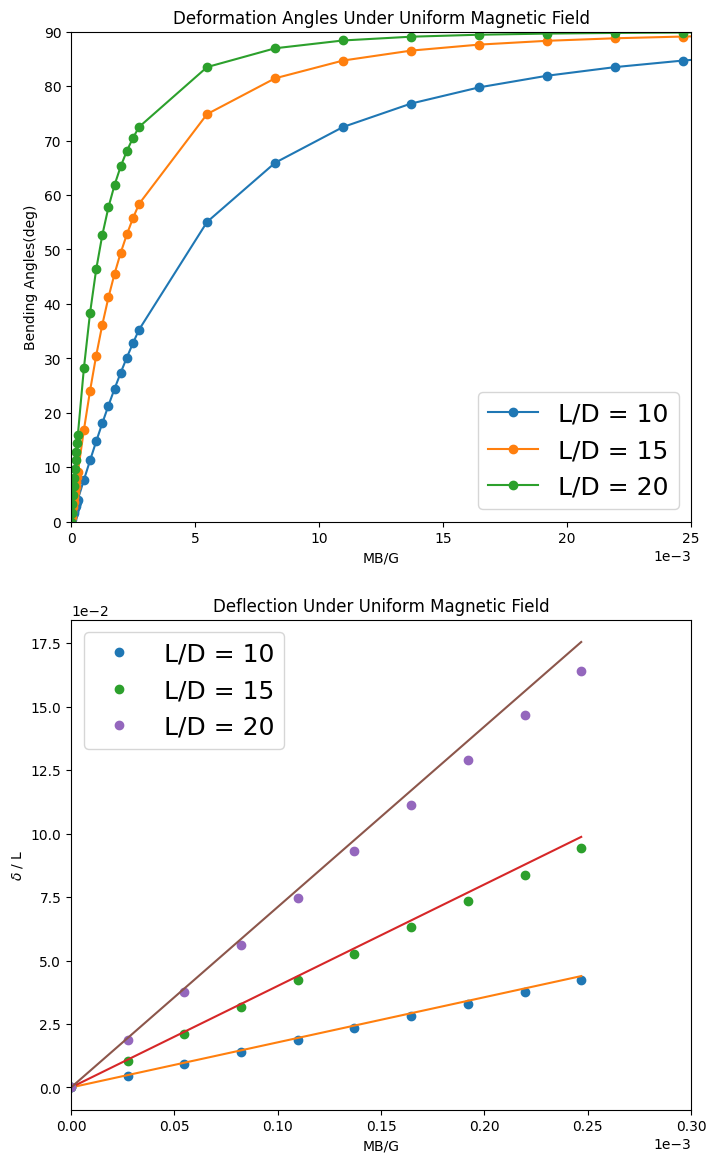

In [56]:

fig = plt.figure(figsize=(8,14))
ax = fig.add_subplot(211)
plt.title("Deformation Angles Under Uniform Magnetic Field")
plt.xlabel("MB/G")
plt.ylabel("Bending Angles(deg)")
x = 1e-3*magnetic_amplitudes*magnetization_density/(shear_modulus*scale_E)
for i in range(r_size):
    ax.plot(
        x,angles[i],
        'o-',
        label = f"L/D = {length_diameter_ratio[i]:.0f}"
    )
ax.set_ylim(0,90)
ax.set_xlim(0,25e-3)
ax.ticklabel_format(style="sci",scilimits=(-3,-3),axis="x")
ax.legend(prop ={"size":18}, loc = "lower right")

ax2 = fig.add_subplot(212)
plt.title("Deflection Under Uniform Magnetic Field")
plt.xlabel("MB/G")
plt.ylabel("$\delta$ / L")
for i in range(r_size):
    ax2.plot(
        x[:small_scope_size], delta_div_L[i,:small_scope_size],
        'o',
        label = f"L/D = {length_diameter_ratio[i]:.0f}",
    )
    ax2.plot(
        x[:small_scope_size], 16/9*x[:small_scope_size]*length_diameter_ratio[i]**2
    )
ax2.set_xlim(0,3e-4)
ax2.ticklabel_format(style="sci",scilimits=(-3,-3),axis="x")
ax2.ticklabel_format(style="sci",scilimits=(-2,-2),axis="y")
ax2.legend(prop ={"size":18}, loc = "upper left")
plt.show()

In [39]:
5//2

2